In [92]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline

In [120]:
df_trans = pd.read_excel('./data_friday_ai.xlsx', engine='openpyxl')
df_trans=df_trans.drop(['customer_id','employee_id','invoice_no.','trans_price'],axis=1)

df=df_trans[(df_trans['store_id']==1)&(df_trans['item_id']==3)]
df=df.drop(['store_id','item_id'],axis=1)

In [121]:
df['time_stamp']=pd.to_datetime(df['time_stamp'])

df=df.sort_values(by=['time_stamp'], ascending=[True])

In [122]:
df=df.groupby(['time_stamp']).sum()
df['dt']=df.index
df=df.set_index('dt')

In [123]:
# r = pd.date_range(start=df.dt.min(), end=df.dt.max())
# df=df.set_index('dt').reindex(r).fillna(0.0).rename_axis('dt').reset_index()

In [124]:
# df['dt']=df.index

# df['week']=pd.DatetimeIndex(df.index).month
df['week']=df.index.isocalendar().week
df=df.groupby(['week']).sum()

In [125]:
df.head()

,quantity
week,
1,2
2,5
3,5
5,2
6,2


<AxesSubplot:xlabel='week'>

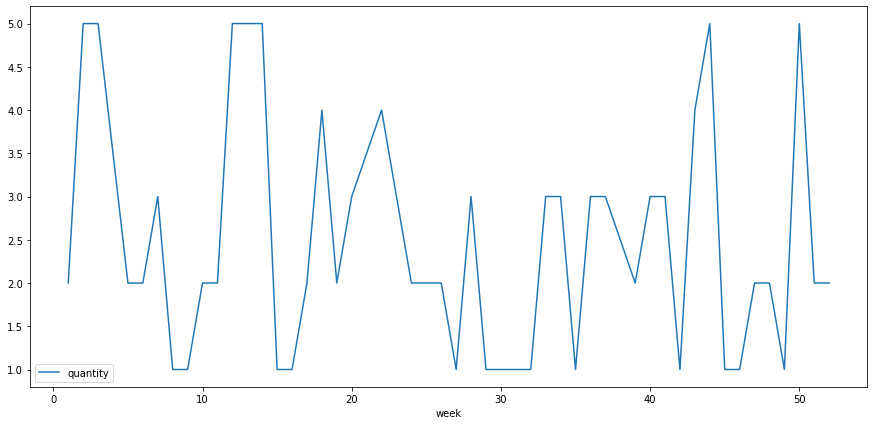

In [126]:


from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
df.plot()

In [127]:
from statsmodels.tsa.stattools import adfuller


test_result=adfuller(df['quantity'])

In [128]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

        

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df['quantity'])

ADF Test Statistic : -5.638653237468662
p-value : 1.0487982914721741e-06
#Lags Used : 0
Number of Observations : 47
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [129]:
df['Sales First Difference'] = df['quantity'] - df['quantity'].shift(1)
df['Seasonal First Difference']=df['quantity']-df['quantity'].shift(1)
df.head()

,quantity,Sales First Difference,Seasonal First Difference
week,,,
1,2,NaN,NaN
2,5,3.0,3.0
3,5,0.0,0.0
5,2,-3.0,-3.0
6,2,0.0,0.0


In [130]:
# Again testing if data is stationary
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -5.588739869806898
p-value : 1.3441808282079166e-06
#Lags Used : 7
Number of Observations : 39
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<AxesSubplot:xlabel='week'>

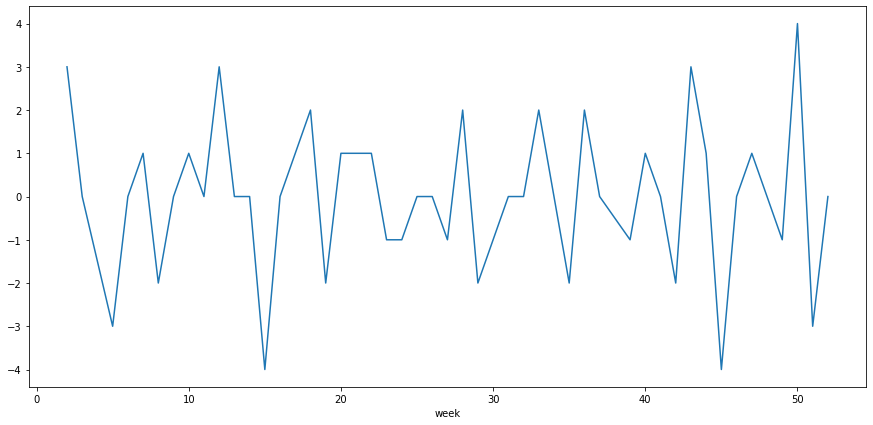

In [131]:
df['Seasonal First Difference'].plot()

/Users/mingze/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


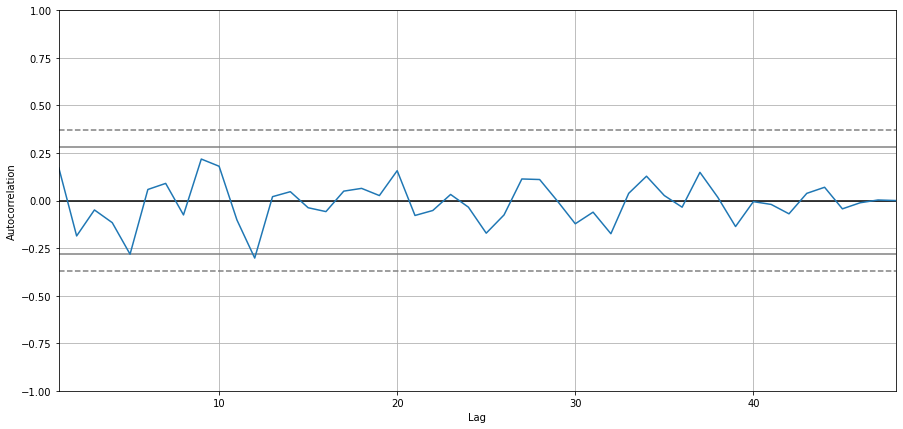

In [132]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['quantity'])
plt.show()

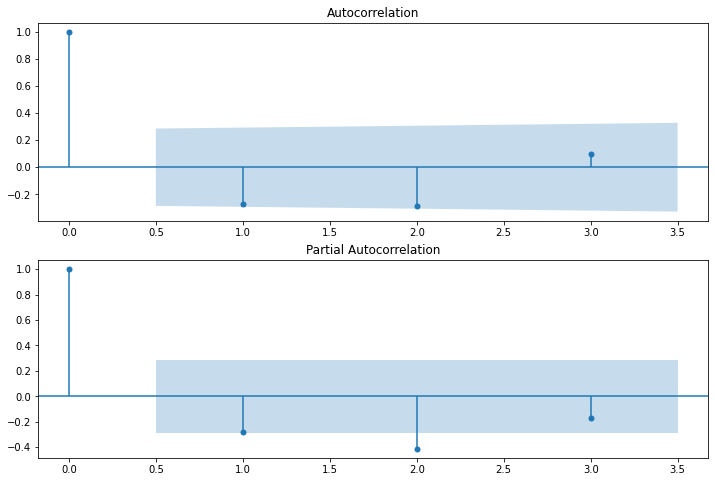

In [133]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].dropna(),lags=3,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].dropna(),lags=3,ax=ax2)

In [134]:
# For non-seasonal data
#p=1, d=1, q=0 or 1

from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(df['quantity'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

/Users/mingze/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/mingze/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been pr

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.quantity   No. Observations:                   47
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -81.585
Method:                       css-mle   S.D. of innovations              1.322
Date:                Thu, 02 Sep 2021   AIC                            171.170
Time:                        13:37:52   BIC                            178.570
Sample:                             1   HQIC                           173.955
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0141      0.016     -0.855      0.393      -0.046       0.018
ar.L1.D.quantity     0.1736      0.145      1.194      0.233      -0.111       0.459
ma.L1.D.quantity    -0.9999      0.058    -17.342      0.000      -1.113      -0.887
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            5.7616           +0.0000j            5.7616            0.0000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [135]:
# df['forecast']=model_fit.predict(start=40,end=45,dynamic=True)
# df[['quantity','forecast']].plot(figsize=(12,8))

/Users/mingze/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/mingze/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/mingze/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/Users/mingze/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported

<AxesSubplot:xlabel='week'>

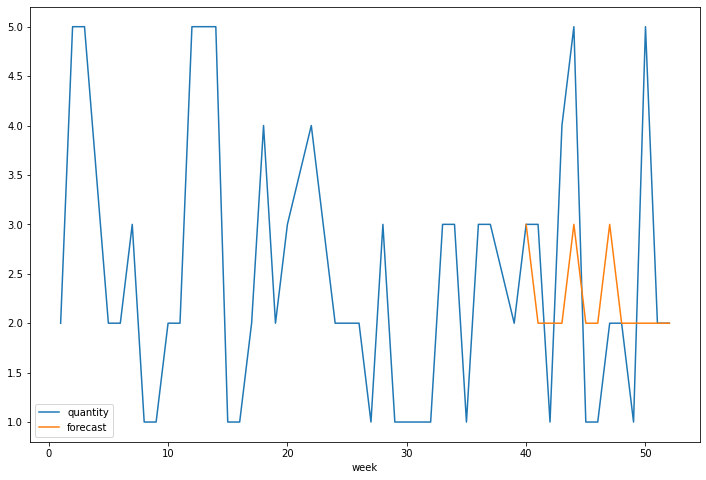

In [139]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['quantity'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
df['forecast']=results.predict(start=40,end=52,dynamic=True)
df['forecast']=round(df['forecast'],0)
df[['quantity','forecast']].plot(figsize=(12,8))

In [140]:
df

,quantity,Sales First Difference,Seasonal First Difference,forecast
week,,,,
1,2,NaN,NaN,NaN
2,5,3.0,3.0,NaN
3,5,0.0,0.0,NaN
5,2,-3.0,-3.0,NaN
6,2,0.0,0.0,NaN
7,3,1.0,1.0,NaN
8,1,-2.0,-2.0,NaN
9,1,0.0,0.0,NaN
10,2,1.0,1.0,NaN
